# Light GBM Model

#### cv score :  0.551735415039368 (5 even fold)
#### cv score :  0.5526119245461704 (5 mode even fold, not onehot)


cv score :  0.5490586011342156

In [36]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
import lightgbm as lgb
from lightgbm import LGBMClassifier


FEATURE_SELECTION = False
tgt_encode = False

random.seed(0)

pd.set_option("display.max_columns", 700)
pd.set_option("display.max_rows", 700)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "distant-range_sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [6]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [7]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング


In [8]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)

# level inverse
#train_df, test_df = prepro.level_inverse(train_df, test_df)
#train_df = prepro.add_numeric_info(train_df, ["level-inverse"])
#test_df = prepro.add_numeric_info(test_df, ["level-inverse"])

#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank
train_df, test_df = prepro.match_rank(train_df, test_df)



reskin
mainweapon
subweapon
special
mizumashi


In [9]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 708)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 902)
complete


In [10]:
# categorize team , 良い

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [11]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")

In [27]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, scaler=False, verbose=False)

complete


# onehot 落としてみる？

In [ ]:
#drop_cols = [col for col in X.columns if "onehot" in col]
#X = X.drop(columns=drop_cols)
#test_X = test_X.drop(columns=drop_cols)

# レベル落とす

In [ ]:
"""drop_cols = ["A1-level", "A2-level", "A3-level", "A4-level", "B1-level", "B2-level", "B3-level", "B4-level"]
X = X.drop(columns=drop_cols)
test_X = test_X.drop(columns=drop_cols)"""
"""level_cols = [col for col in X.columns if "level" in col]
X = X.drop(columns=level_cols)
test_X = test_X.drop(columns=level_cols)"""

In [29]:
print(X.shape)
print(test_X.shape)

(132250, 922)
(28340, 922)


# 特徴選択
gbdtは内部で特徴選択を行うのでおそらく使用しないほうがいい

In [30]:
if FEATURE_SELECTION:
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()
    clf.fit(X, y)
    importance = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
    display(importance*10000)
    use_cols = importance.index[:450]
else:
    print("No feature selection")


No feature selection


In [31]:
cat_tgtenc_cols = [
    "mode", "stage", "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B", "mode * team-category1-A", "mode * team-category1-B"
]
for col in cat_tgtenc_cols:
    print(train_df[col].unique().shape[0], col)

5 mode
23 stage
138 team-category1-A
138 team-category1-B
735 team-category2-A
735 team-category2-B
1853 team-subweapon-A
1853 team-subweapon-B
2588 team-special-A
2588 team-special-B
515 mode * team-category1-A
515 mode * team-category1-B


# モデル学習

In [37]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = [
    "mode", "stage", "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"
]
cat_tgtenc_cols = ["mode * team-category1-A", "mode * team-category1-B"]

# folds = prepro.make_kfolds(SIZE, K)
#folds = prepro.make_stratified_kfolds(X, y, K)
folds = prepro.make_stratified_kfolds(X, (train_df["mode"] + y.astype(str)), K, shuffle=True)
#folds = prepro.make_mode_even_kfolds(X, y, K)

print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
# 
#X = X[use_cols]
#test_X = test_X[use_cols]

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [38]:
param = {
    "num_leaves" : 28,
    #"learning_rate" : 0.01,
    #"learning_rate" : 0.05,
    "learning_rate" : 0.1,
    "num_iterations" : 20000,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
    "random_state" : random.randint(0, 10000),
    #"random_state" : 0,
    "max_depth" : 100
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []


all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    if tgt_encode:
        for col in cat_tgtenc_cols:
            print(col)
            train_X, valid_X = prepro.target_encoding(train_X, valid_X, train_y, col, "y")
        
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    
    model = lgb.train(
        param, 
        train_data, 
        valid_sets=valid_data, 
        #categorical_feature=categorical_feature,
        early_stopping_rounds=50, 
        verbose_eval=100,
        
    )
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
mode * team-category1-A
mode * team-category1-B
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.685351
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.683463
======================== fold 2 ========================
mode * team-category1-A
mode * team-category1-B
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.681972
[200]	valid_0's binary_logloss: 0.682036
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.681761
======================== fold 3 ========================
mode * team-category1-A
mode * team-category1-B
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.684923
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.68432
======================== fold 4 ========================
mode * team-category1-A
mode * team-category1-B
Training

mode * team-category1-A
mode * team-category1-B
0.5098255412501256
0.5108421910023838
0.5103454592879105
0.5100631035168863
0.5104727057492995
0.5103098001613211


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

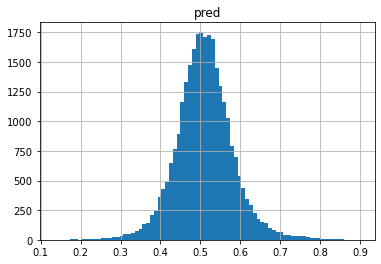

In [39]:
preds = []
if tgt_encode:
    for col in cat_tgtenc_cols:
        print(col)
        X, test_X = prepro.target_encoding(X, test_X, y, col, "y")

for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [40]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
#submit_df.to_csv('../Submissions/submission11_{}.csv'.format(K))

0.573712067748765


# モデル解釈

In [54]:
importance = pd.DataFrame(models[1].feature_importance(), index=test_X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance.iloc[:100])

,importance
B-level-median,70
A-level-median,63
B1-level,38
B-level-max,34
A4-level,34
A1-level,32
B3-level,32
A-level-max,32
A-level-sum,30
A-level-min,29


In [50]:
indices = [index for index in importance.index if "B2" in index]
importance.loc[indices]

,importance
mainweapon-B2-count-by-mode,26
B2-level,20
reskin-B2-count-by-mode,15
reskin-B2-count,12
reskin-B2,10
vote-main-B2,8
special-B2-count-by-mode,8
subweapon-B2-count-by-mode,7
range-main-B2,6
mainweapon-B2,6


In [ ]:
importance["importance"].sum()

In [ ]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
result_df.to_csv("../../data/result.csv", index=False)

In [ ]:
print(train_df[train_df["mode"] == "nawabari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "hoko"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "asari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "area"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "yagura"].shape[0]/train_df.shape[0])

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df.loc[:100]

In [ ]:
num_cols_ = [
    "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]


In [ ]:
feature_cols = []
for name in num_cols_:
    for col in X.columns:
        if name in col:
            feature_cols.append(col)
                
importance.loc[feature_cols]#.sort_values('importance', ascending=False)

In [ ]:
sss = []

"""
A-direct_range-sub-mean 30
A-distant_range_sub-max
B-rapid-std	52
ink-sub
A-kill_time_human-main-median	36
A-kill_time_ika-main-median	58
A-front_gap_human-main-std	25
A-front_gap_ika-main-std	48
A-saidai_damege-main-mean	40
damage_max-sub 37
install_num-sub 10
direct_range-sub 30
damage_max-special 47
duration-special 46
close_rad-special 30
distant_rad-special 21
"""




for col in X.columns:
    if "distant_rad-special" in col:
        sss.append(col)
                
importance.loc[sss].sort_values('importance', ascending=False)

In [ ]:
cat_tgtenc_cols = [
    "mode", "stage", "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-mainweapon-A", "team-mainweapon-B", "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"
]
for col in cat_tgtenc_cols:
    print(col, train_df[col].unique().shape[0])

In [ ]:
cols = [col for col in X.columns if "A1" in col or "A2" in col or "A3" in col or "A4" in col
        or "B1" in col or "B2" in col or "B3" in col or "B4" in col ]
X = X.drop(columns=cols)
test_X = test_X.drop(columns=cols)